## **Импорт библиотек**

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.vision import *
from fastai import *
import fastai
from fastai.callbacks.hooks import *

import pickle

import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score

## **Описание вспомогательных функций**

In [2]:
def display_image_mask_grid(n):
  images_list = []
  for i in range(n):
    images_list.append(random.choice(os.listdir(img_path)))
  for idx, image in enumerate(images_list):  
    fig, axs = plt.subplots(1, 2, figsize=(10, 10))
    img = plt.imread(str(img_path/image))
    axs[0].imshow(img)
    msk = plt.imread(str(mask_path/image))
    axs[1].imshow(msk, cmap='gray')    
    plt.grid(False)
    plt.show() 

In [3]:
class MaskSegmentationLabelList(SegmentationLabelList):
    def open(self, fn): 
      return open_mask(fn, div=True)

class MaskSegmentationItemList(ImageList):
    _label_cls,_square_show_res = MaskSegmentationLabelList, False

In [4]:
def dice_loss(input, target):
    smooth = 1.
    input = input[:,1,None].sigmoid()
    iflat = input.contiguous().view(-1).float()
    tflat = target.view(-1).float()
    intersection = (iflat * tflat).sum()
    return (1 - ((2. * intersection + smooth) / ((iflat + tflat).sum() +smooth)))

def combo_loss(pred, targ):
    bce_loss = CrossEntropyFlat(axis=1)
    return bce_loss(pred,targ) + dice_loss(pred,targ)
    

## **Указание пути и проверка исходных данных**

In [5]:
from fastai.vision import *
#src_path = Path('/content/AerialImageDataset/gt')
root_path = Path('/content/drive/My Drive/Netology/Datasets/InriaDataset/gt')

#image_hr_path = src_path/'train/images'
#mask_hr_path = src_path/'train/gt'
#test_hr_path = src_path/'test/images'

image_lr_path = root_path/'train'
test_lr_path = root_path/'test'
train_mask_lr_path = root_path/'masks'

#hr_images = ImageList.from_folder(image_hr_path)
#hr_masks = ImageList.from_folder(mask_hr_path)
#hr_tests = ImageList.from_folder(test_hr_path)

In [6]:
images = get_image_files(image_lr_path)
masks = get_image_files(train_mask_lr_path)
len(images),len(masks)

(720, 720)

In [7]:
root_dir = Path('/content/drive/My Drive/Netology/Datasets/InriaDataset/gt')
train_path = root_dir/'train'
test_path = root_dir/'test'
mask_path = root_dir/'masks'
img_path = train_path
img_path, mask_path

(PosixPath('/content/drive/My Drive/Netology/Datasets/InriaDataset/gt/train'),
 PosixPath('/content/drive/My Drive/Netology/Datasets/InriaDataset/gt/masks'))

In [8]:
images = get_image_files(img_path)
masks = get_image_files(mask_path)
len(images),len(masks)

(720, 720)

In [10]:
# Size of each image and its mask
image = open_image(images[0])
img_size = np.array(image.shape[1:])
print(image.shape)

mask = open_mask(masks[0], div=True)
print(mask.shape)
mask_size = np.array(mask.shape[1:])
print(mask.data)

np.unique(np.array(mask.data))

torch.Size([3, 2224, 2224])
torch.Size([1, 224, 224])
tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]])


array([0, 1])

In [11]:
get_mask_file = lambda x: mask_path/f'{x.stem.split("/")[-1]}.tif'
img = images[0]
img, get_mask_file(img)

(PosixPath('/content/drive/My Drive/Netology/Datasets/InriaDataset/gt/train/austin8-4.tif'),
 PosixPath('/content/drive/My Drive/Netology/Datasets/InriaDataset/gt/masks/austin8-4.tif'))

## **Визуализация данных**

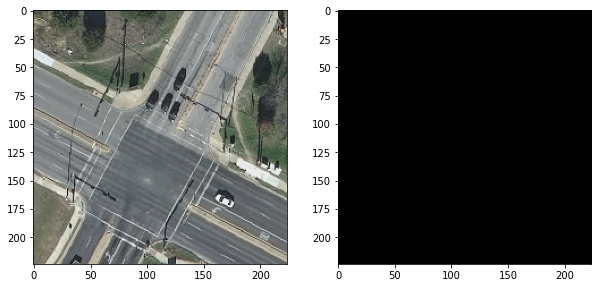

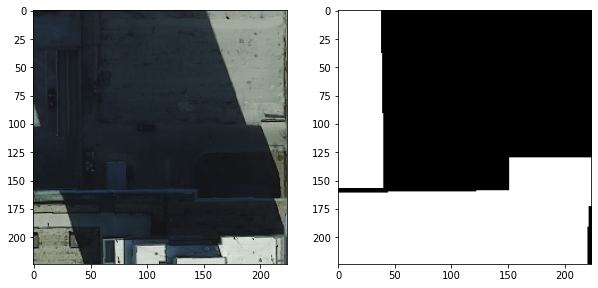

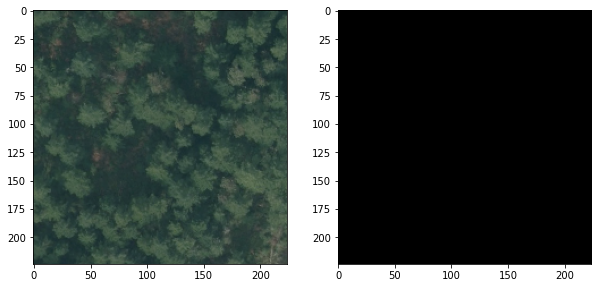

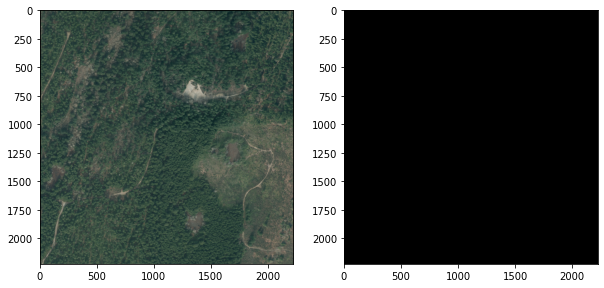

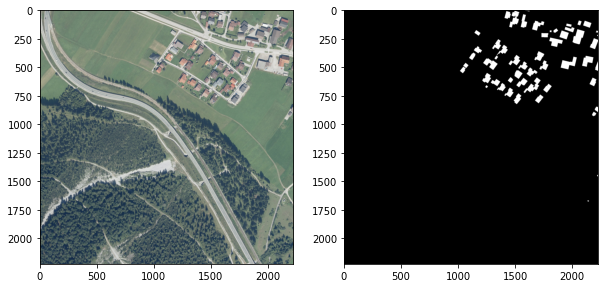

In [12]:
display_image_mask_grid(5)

### **Подготовка к обучению модели**

In [13]:
# Parameters
codes = np.array(['NotBuilding','Building'])
src_size = np.array(mask.shape[1:])
size = src_size
bs = 3


In [16]:
src = MaskSegmentationItemList.from_folder(train_path).split_by_fname_file(root_dir/'valid.txt').label_from_func(get_mask_file, classes=codes)
tfms = get_transforms(flip_vert=True, max_warp=0, max_zoom=1.2, max_lighting=0.3)
data = (src.transform(tfms, size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats)
)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale

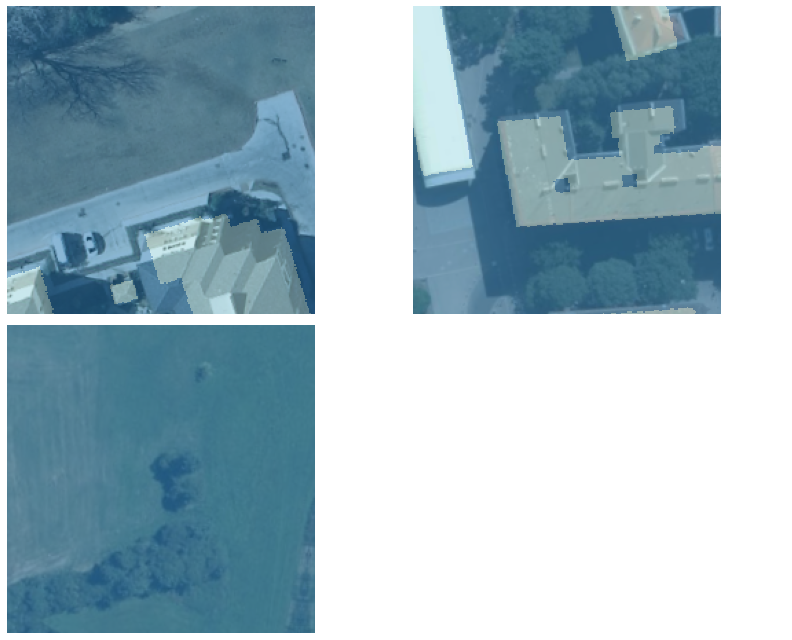

In [17]:
data.show_batch(rows=3, figsize=(12,9))

In [18]:
len(data.train_ds.x.items), len(data.train_ds.y.items),len(data.valid_ds.x.items), len(data.valid_ds.y.items)

(670, 670, 50, 50)

In [19]:
 # Labels
data.classes

array(['NotBuilding', 'Building'], dtype='<U11')

## **Описание метрики**

In [20]:
metrics1=[accuracy_thresh, dice]
metrics2=[accuracy_thresh, dice]
learn = unet_learner(data, models.vgg16_bn, metrics=metrics2)
learn.metrics = metrics1

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [22]:
recompute_scale_factor=True
learn.freeze()
learn.lr_find()
learn.recorder.plot()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


KeyboardInterrupt: ignored

## **Обучение модели**

In [23]:
lr = 1e-03
learn.fit_one_cycle(10, slice(lr))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale

In [24]:
learn.save("stage-1-vgg_d-512")

In [25]:
learn.fit_one_cycle(10, slice(lr))


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale

In [26]:
lr = 1e-04
learn.fit_one_cycle(10, slice(1e-6,lr))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale

In [27]:
learn.save("stage-2-vgg_d-512")

In [28]:
learn = learn.load("stage-2-vgg_d-512")

In [29]:
# Training the cycle for 20 epochs
learn.fit_one_cycle(20, max_lr=slice(1e-5,lr))

Выходные данные были обрезаны до нескольких последних строк (5000).
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details

In [46]:
learn.save("/content/drive/My Drive/Netology/Datasets/InriaDataset/gt/stage-3-vgg_d-512")

In [47]:
 learn = learn.load("/content/drive/My Drive/Netology/Datasets/InriaDataset/gt/stage-3-vgg_d-512")

In [45]:
torch.save(learn.model, "/content/drive/My Drive/Netology/Datasets/InriaDataset/gt/model.pt") 
model = torch.load("/path/to/model.pt")

AttributeError: ignored

In [32]:
outputs = learn.pred_batch(ds_type=DatasetType.Valid)
outputs.shape

torch.Size([3, 2, 224, 224])

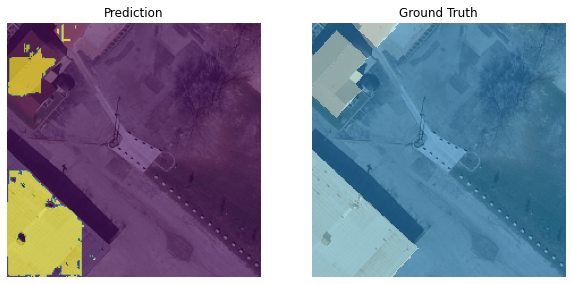

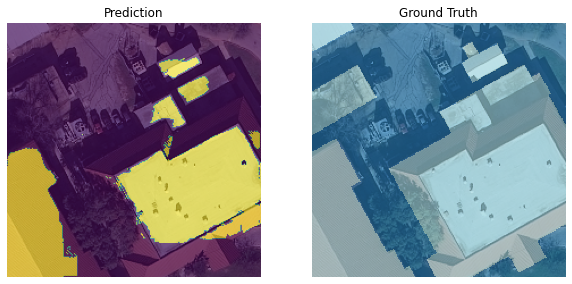

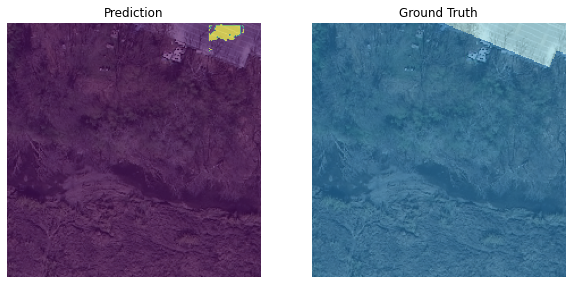

In [36]:
for i in range(bs):

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

    data.valid_ds.x[i].show(ax=ax1)
    ax1.set_title('Prediction')
    ax1.imshow((to_np(outputs[i][1].sigmoid()>0.70)), alpha=0.6)
    
    ax2.set_title('Ground Truth')
    data.valid_ds.x[i].show(ax=ax2)
    data.valid_ds.y[i].show(ax=ax2, alpha=0.6)
    plt.show()

## **Проверка на тестовых данных**

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


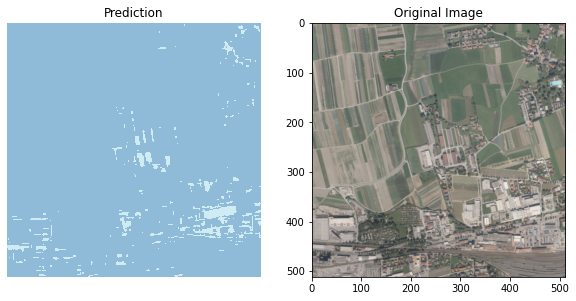

In [37]:
img = open_image(test_path/'innsbruck12.tif')
prediction = learn.predict(img)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
ax1.set_title('Prediction')
prediction[0].show(figsize=(5,5), ax=ax1)
ax2.set_title('Original Image')
img = plt.imread(str(test_path/'innsbruck12.tif'))
ax2.imshow(img)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


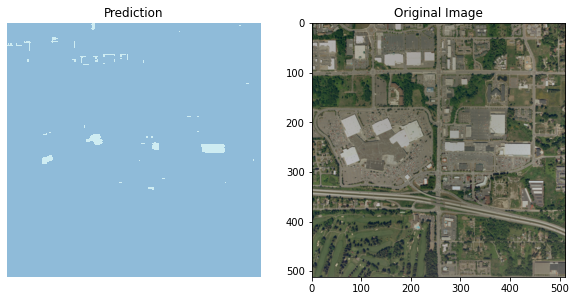

In [38]:
img = open_image(test_path/'bellingham23.tif')
prediction = learn.predict(img)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
ax1.set_title('Prediction')
prediction[0].show(figsize=(5,5), ax=ax1)
ax2.set_title('Original Image')
img = plt.imread(str(test_path/'bellingham23.tif'))
ax2.imshow(img)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


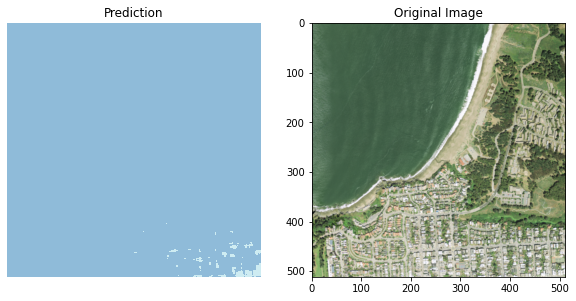

In [40]:
img = open_image(test_path/'sfo6.tif')
prediction = learn.predict(img)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
ax1.set_title('Prediction')
prediction[0].show(figsize=(5,5), ax=ax1)
ax2.set_title('Original Image')
img = plt.imread(str(test_path/'sfo6.tif'))
ax2.imshow(img)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


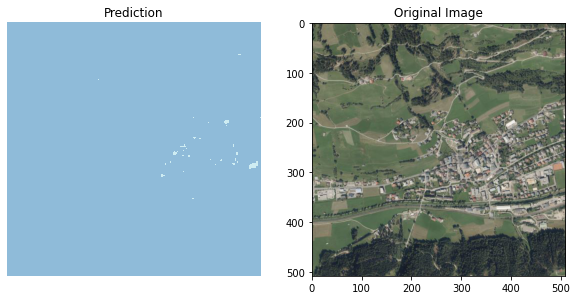

In [43]:
img = open_image(test_path/'tyrol.JPG')
prediction = learn.predict(img)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
ax1.set_title('Prediction')
prediction[0].show(figsize=(5,5), ax=ax1)
ax2.set_title('Original Image')
img = plt.imread(str(test_path/'tyrol.JPG'))
ax2.imshow(img)